Running Chikungunya simulation (Revised Progression: Im -> Is)...
Basic Reproduction Number (R0) Estimate: 2.270


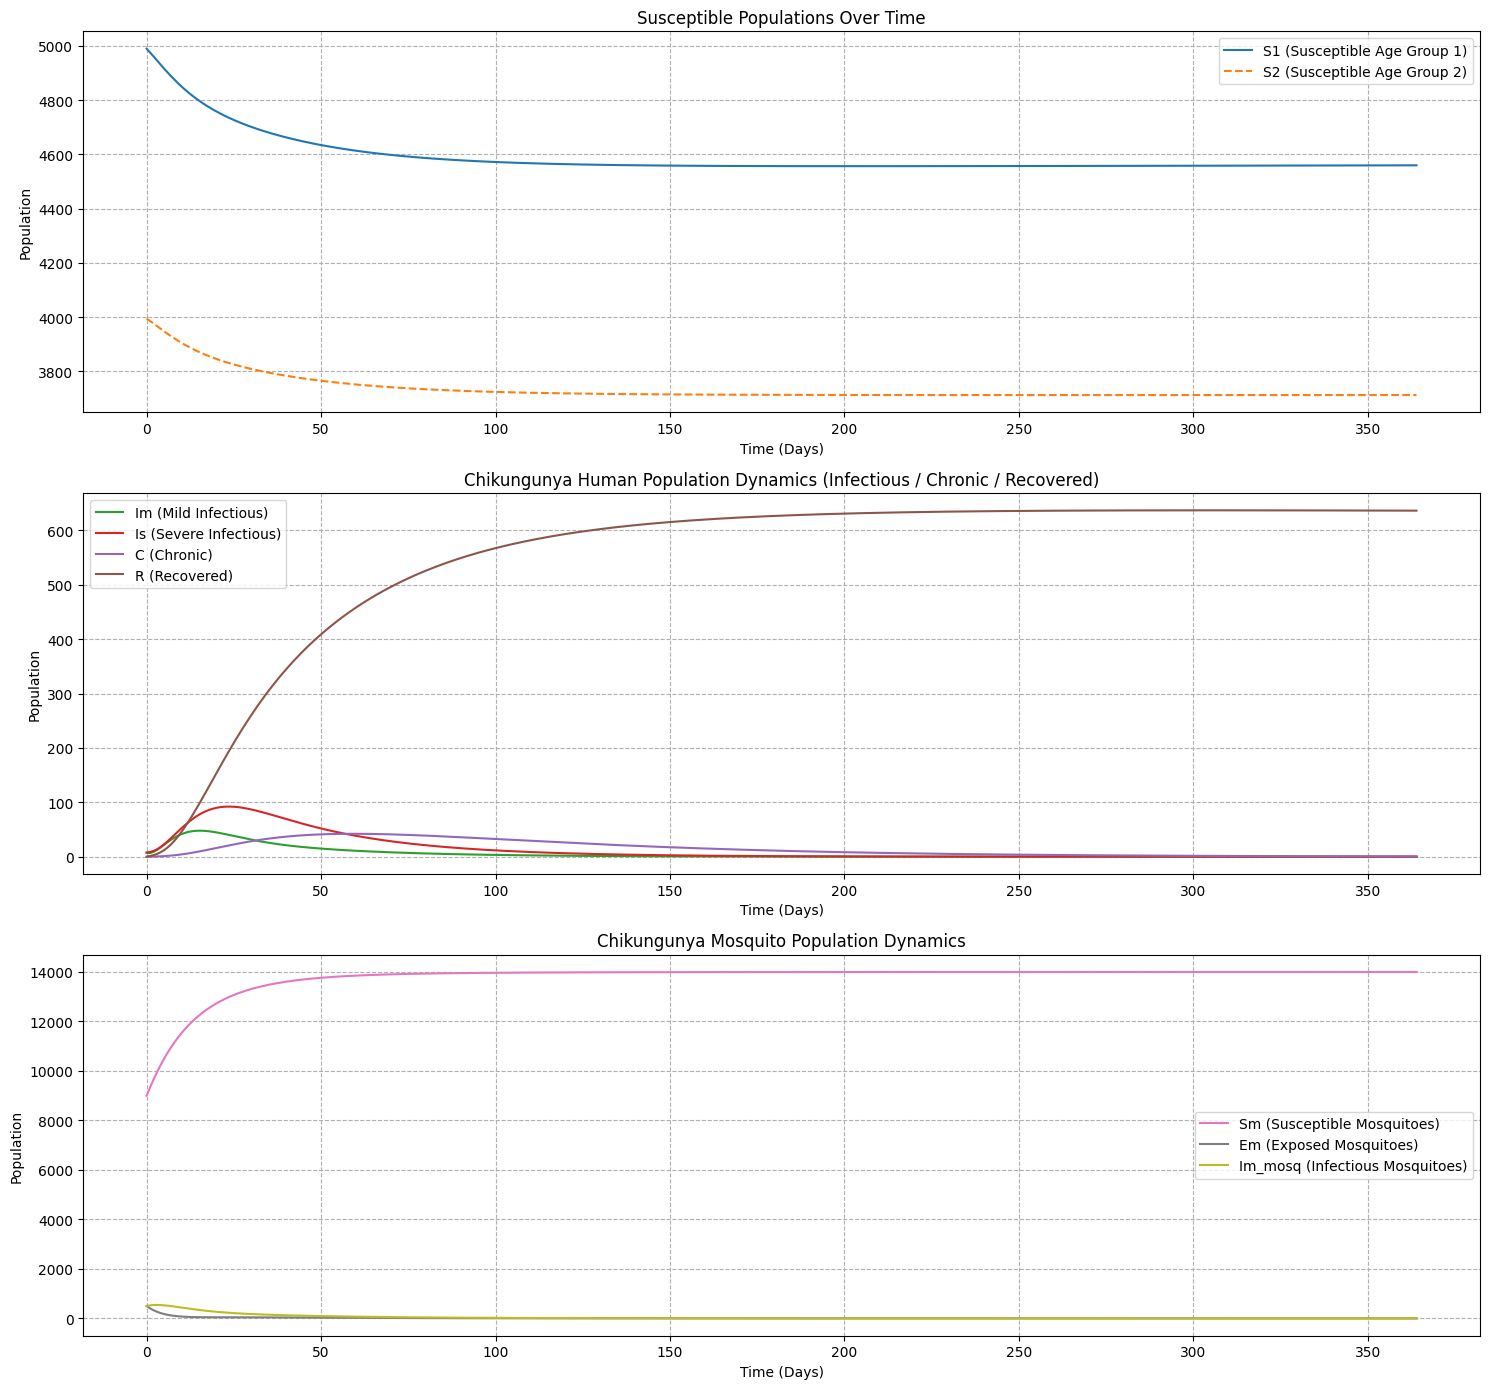

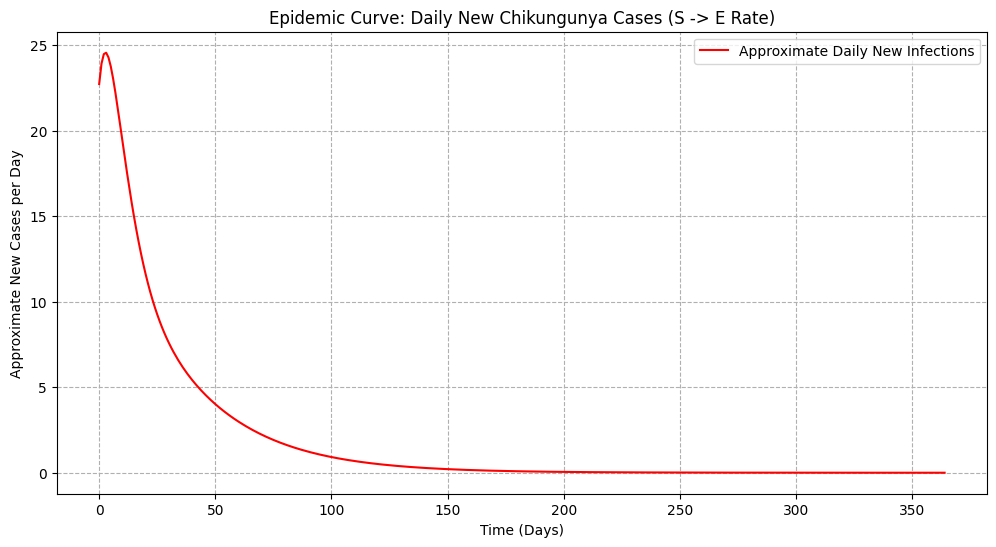


Final Populations (After 1 Years):
Total Infectious: 0
Chronic Cases: 1
Recovered: 636
Total Mosquitoes: 14000


In [1]:
# -*- coding: utf-8 -*-
"""
CHIKUNGUNYA MODEL - KENYA (REVISED PROGRESSION)
------------------------------------------------------
Flow: E -> Im -> {R, Is}; Is -> {R, C}; C -> R
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# -----------------------------------------------------------------------------
# CORE MODEL EQUATIONS (REVISED - Returns only 11 Derivatives)
# -----------------------------------------------------------------------------
def chikungunya_model_core(y, t, p):
    # Unpack parameters
    mu, sigma, gamma_m, gamma_s, gamma_c, \
    severe_prob_1, severe_prob_2, chronic_prob_s, mu_ms, \
    contact_rate_1, contact_rate_2, \
    prop_age1_Im, prop_age1_Is, prop_age1_C, prop_age1_R, \
    Lambda_m, mu_m, sigma_m, b, beta_hm, beta_mh = p.values()
    
    # Unpack state variables (11 elements)
    S1, E1, S2, E2, Im, Is, C, R, Sm, Em, Im_mosq = y
    
    # Total human populations (approximation using initial proportions for Im, Is, C, R)
    N1 = S1 + E1 + prop_age1_Im * Im + prop_age1_Is * Is + prop_age1_C * C + prop_age1_R * R
    N2 = S2 + E2 + (1 - prop_age1_Im) * Im + (1 - prop_age1_Is) * Is + (1 - prop_age1_C) * C + (1 - prop_age1_R) * R
    N_total = N1 + N2
    
    # Total infectious humans
    I_total = Im + Is
    
    # Force of infection
    lambda_h = b * beta_mh * Im_mosq / N_total
    lambda_m = b * beta_hm * I_total / N_total
    
    # Age-specific FOI
    lambda_h1 = lambda_h * contact_rate_1
    lambda_h2 = lambda_h * contact_rate_2
    
    # Differential equations (Human)
    dS1 = mu * N1 - mu * S1 - lambda_h1 * S1
    dE1 = lambda_h1 * S1 - (sigma + mu) * E1

    dS2 = mu * N2 - mu * S2 - lambda_h2 * S2
    dE2 = lambda_h2 * S2 - (sigma + mu) * E2
    
    dIm = (sigma * (1 - severe_prob_1) * E1) + \
          (sigma * (1 - severe_prob_2) * E2) - \
          (mu + gamma_m + mu_ms) * Im
          
    dIs = (sigma * severe_prob_1 * E1) + \
          (sigma * severe_prob_2 * E2) + \
          (mu_ms * Im) - \
          (mu + gamma_s + chronic_prob_s * gamma_s) * Is
          
    dC = (chronic_prob_s * gamma_s * Is) - (mu + gamma_c) * C
    
    dR = (gamma_m * Im) + \
         ((1 - chronic_prob_s) * gamma_s * Is) + \
         (gamma_c * C) - \
         (mu * R)
    
    # Differential equations (Mosquito)
    dSm = Lambda_m - mu_m * Sm - lambda_m * Sm
    dEm = lambda_m * Sm - (sigma_m + mu_m) * Em
    dIm_mosq = sigma_m * Em - mu_m * Im_mosq
    
    # Return 11 derivatives for the ODE solver
    return [dS1, dE1, dS2, dE2, dIm, dIs, dC, dR, dSm, dEm, dIm_mosq]


# -----------------------------------------------------------------------------
# SIMULATION FUNCTION (Fixed to correctly handle ODE and Incidence)
# -----------------------------------------------------------------------------
def run_chikungunya_simulation_revised(params, y0, t):
    # 1. Run the ODE solver with the core function (returns 11 derivatives)
    sol = odeint(chikungunya_model_core, y0, t, args=(params,))
    
    columns = ["S1","E1","S2","E2","Im","Is","C","R","Sm","Em","Im_mosq"]
    results = pd.DataFrame(sol, columns=columns)
    results["time"] = t

    # 2. Calculate the Incidence Rate separately
    incidence_list = []
    
    # Unpack parameters needed for incidence calculation
    _, _, _, _, _, severe_prob_1, severe_prob_2, _, _, \
    contact_rate_1, contact_rate_2, \
    prop_age1_Im, prop_age1_Is, prop_age1_C, prop_age1_R, \
    Lambda_m, mu_m, sigma_m, b, beta_hm, beta_mh = params.values()
    
    for _, row in results.iterrows(): #calculate incidence at each time point 
        S1, E1, S2, E2, Im, Is, C, R, Sm, Em, Im_mosq = row[columns] 
        
        # Recalculate N_total and lambda_h for the current state
        N1 = S1 + E1 + prop_age1_Im * Im + prop_age1_Is * Is + prop_age1_C * C + prop_age1_R * R
        N2 = S2 + E2 + (1 - prop_age1_Im) * Im + (1 - prop_age1_Is) * Is + (1 - prop_age1_C) * C + (1 - prop_age1_R) * R
        N_total = N1 + N2
        
        lambda_h = b * beta_mh * Im_mosq / N_total
        lambda_h1 = lambda_h * contact_rate_1
        lambda_h2 = lambda_h * contact_rate_2
        
        # Incidence is the rate of new infections (S -> E)
        new_incidence_rate = lambda_h1 * S1 + lambda_h2 * S2
        incidence_list.append(new_incidence_rate)
        
    results["Incidence_Rate"] = incidence_list
    
    return results


# -----------------------------------------------------------------------------
# R0 CALCULATION (Simplified Estimate) 
# -----------------------------------------------------------------------------
def calculate_R0_revised(params):
    mu, sigma, gamma_m, gamma_s, gamma_c, \
    severe_prob_1, severe_prob_2, chronic_prob_s, mu_ms, \
    contact_rate_1, contact_rate_2, \
    prop_age1_Im, prop_age1_Is, prop_age1_C, prop_age1_R, \
    Lambda_m, mu_m, sigma_m, b, beta_hm, beta_mh = params.values()

    avg_infectious_period_mild = 1 / (gamma_m + mu_ms + mu)
    avg_infectious_period_severe = 1 / (gamma_s + chronic_prob_s * gamma_s + mu) 
    
    avg_severe_prob = (severe_prob_1 + severe_prob_2) / 2
    
    avg_infectious_duration_effective = (1 - avg_severe_prob) * avg_infectious_period_mild + avg_severe_prob * avg_infectious_period_severe
    
    prob_transmission_m = sigma_m / (sigma_m + mu_m) 
    
    R0_simple = (b**2 * beta_hm * beta_mh * prob_transmission_m * avg_infectious_duration_effective * (1 / mu_m)) / mu_m
    
    return R0_simple

# -----------------------------------------------------------------------------
# PLOTTING FUNCTIONS
# -----------------------------------------------------------------------------
def plot_chikungunya_results(results):
    """Plots the overall compartmental dynamics including susceptibles."""
    plt.figure(figsize=(15, 14))
    
    # Susceptible Populations
    plt.subplot(3, 1, 1)
    plt.plot(results['time'], results['S1'], label='S1 (Susceptible Age Group 1)', color='C0')
    plt.plot(results['time'], results['S2'], label='S2 (Susceptible Age Group 2)', color='C1', linestyle='--')
    plt.title('Susceptible Populations Over Time')
    plt.xlabel('Time (Days)')
    plt.ylabel('Population')
    plt.grid(True, linestyle='--')
    plt.legend()
    
    # Human Populations (Infectious / Chronic / Recovered)
    plt.subplot(3, 1, 2)
    plt.plot(results['time'], results['Im'], label='Im (Mild Infectious)', color='C2')
    plt.plot(results['time'], results['Is'], label='Is (Severe Infectious)', color='C3')
    plt.plot(results['time'], results['C'], label='C (Chronic)', color='C4')
    plt.plot(results['time'], results['R'], label='R (Recovered)', color='C5')
    plt.title('Chikungunya Human Population Dynamics (Infectious / Chronic / Recovered)')
    plt.xlabel('Time (Days)')
    plt.ylabel('Population')
    plt.grid(True, linestyle='--')
    plt.legend()
    
    # Mosquito Populations
    plt.subplot(3, 1, 3)
    plt.plot(results['time'], results['Sm'], label='Sm (Susceptible Mosquitoes)', color='C6')
    plt.plot(results['time'], results['Em'], label='Em (Exposed Mosquitoes)', color='C7')
    plt.plot(results['time'], results['Im_mosq'], label='Im_mosq (Infectious Mosquitoes)', color='C8')
    plt.title('Chikungunya Mosquito Population Dynamics')
    plt.xlabel('Time (Days)')
    plt.ylabel('Population')
    plt.grid(True, linestyle='--')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_epi_curve(results):
    """Plots the epidemic curve (daily incidence of new cases)."""
    # The solver uses a small step size (0.5 days). 
    # To get the approximate daily number of new cases, we multiply the rate by the step size.
    time_step = results['time'].diff().mean()
    # Handle the very first point where diff() is NaN
    if np.isnan(time_step):
        # Fallback: assume the step size is the smallest interval, often t[1]-t[0] or 1.0 if not specified.
        time_step = results['time'].iloc[1] - results['time'].iloc[0] if len(results['time']) > 1 else 1.0

    daily_incidence = results['Incidence_Rate'] * time_step
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['time'], daily_incidence, label='Approximate Daily New Infections', color='red')
    plt.title('Epidemic Curve: Daily New Chikungunya Cases (S -> E Rate)')
    plt.xlabel('Time (Days)')
    plt.ylabel('Approximate New Cases per Day')
    plt.grid(True, linestyle='--')
    plt.legend()
    plt.show() # Explicitly show the plot

# -----------------------------------------------------------------------------
# MAIN EXECUTION (Fixed and Completed)
# -----------------------------------------------------------------------------
def main():
    # Parameters (mu_ms added, chronic_prob_m removed)
    params = dict(
        mu = 1/(62*365),       # Human death/birth rate (1/lifespan)
        sigma = 1/5,           # Incubation rate (1/5 days)
        gamma_m = 1/7,         # Recovery rate from Im (Mild)
        gamma_s = 1/14,        # Recovery rate from Is (Severe)
        gamma_c = 1/60,        # Recovery rate from C (Chronic)
        severe_prob_1 = 0.1,   # Probability of E1 going to Is
        severe_prob_2 = 0.7,   # Probability of E2 going to Is
        chronic_prob_s = 0.25, # Fraction of Is that becomes Chronic
        mu_ms = 1/10,          # Progression rate from Im to Is (1/10 days)
        contact_rate_1 = 1.0,
        contact_rate_2 = 0.8,
        prop_age1_Im = 0.9,  
        prop_age1_Is = 0.1,  
        prop_age1_C = 0.2,   
        prop_age1_R = 0.9,   
        Lambda_m = 1000,       # Mosquito birth rate
        mu_m = 1/14,           # Mosquito death rate (1/14 days)
        sigma_m = 1/7,         # Mosquito incubation rate (1/7 days)
        b = 0.5,               # Biting rate
        beta_hm = 0.1,         # Human-to-mosquito transmission probability
        beta_mh = 0.1          # Mosquito-to-human transmission probability
    )

    # Initial conditions (11 elements)
    y0 = [
        5000 - 10,  # S1
        0,             # E1
        4000 - 5,     # S2
        0,             # E2
        7,             # Im
        8,             # Is
        0,             # C
        0,             # R
        9000,          # Sm
        500,           # Em
        500            # Im_mosq
    ]

    t = np.arange(0, 365*1, 1)

    print("Running Chikungunya simulation (Revised Progression: Im -> Is)...")
    results = run_chikungunya_simulation_revised(params, y0, t)

    R0 = calculate_R0_revised(params)
    print(f"Basic Reproduction Number (R0) Estimate: {R0:.3f}")

    # Plotting
    plot_chikungunya_results(results)
    plot_epi_curve(results) 

    # Print summary
    final = results.iloc[-1]
    print("\nFinal Populations (After 1 Years):")
    print(f"Total Infectious: {final['Im'] + final['Is']:.0f}")
    print(f"Chronic Cases: {final['C']:.0f}")
    print(f"Recovered: {final['R']:.0f}")
    print(f"Total Mosquitoes: {final['Sm'] + final['Em'] + final['Im_mosq']:.0f}")
    
    # Return the results and R0 for the final unpack statement
    return results, R0


# -----------------------------------------------------------------------------
# RUN SIMULATION
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    try:
        results, R0 = main()
    except Exception as e:
        print(f"An error occurred during execution: {e}")

In [6]:
results

,S1,E1,S2,E2,Im,Is,C,R,Sm,Em,Im_mosq,time,Incidence_Rate
0,4990.000000,0.000000,3995.000000,0.000000,7.000000,8.000000,0.000000,0.000000,9000.000000,500.000000,500.000000,0,22.738889
1,4975.741781,12.934026,3985.865420,8.286446,6.825470,8.659713,0.145544,1.394855,9343.953183,404.243022,527.552677,1,23.929107
2,4960.963249,23.989390,3976.391966,15.374305,9.007664,10.626222,0.312090,3.018042,9664.044391,327.098607,541.345403,2,24.487951
3,4946.000779,33.203273,3966.794845,21.286749,12.676624,13.774042,0.521425,5.208967,9961.746935,265.136434,544.645643,3,24.569321
4,4931.106501,40.682161,3957.235696,26.091111,17.164690,17.923052,0.792215,8.189606,10238.468559,215.554247,540.068021,4,24.295945
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,4559.796290,0.001516,3713.050018,0.000987,0.001556,0.005418,0.625610,636.501816,13999.986933,0.002965,0.010102,360,0.000427
361,4559.821354,0.001472,3713.052687,0.000959,0.001511,0.005260,0.615337,636.484536,13999.987312,0.002879,0.009809,361,0.000414
362,4559.846425,0.001429,3713.055360,0.000931,0.001467,0.005108,0.605231,636.467072,13999.987681,0.002795,0.009524,362,0.000402
363,4559.871502,0.001387,3713.058038,0.000904,0.001424,0.004959,0.595291,636.449428,13999.988039,0.002714,0.009247,363,0.000391
